# Data Preprocessing

In [0]:
import numpy as np
import pandas as pd
from keras.layers import Dense,LSTM,Flatten, GRU
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

In [0]:
stock_data=pd.read_csv("GOOGL_2006-01-01_to_2018-01-01.csv",parse_dates=['Date'], index_col='Date',date_parser=dateparse)
stock_data.drop('Name',axis=1,inplace=True)

Text(0.5, 1.0, 'Stock Trend')

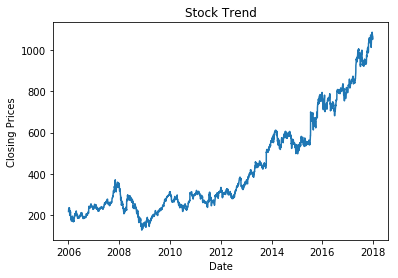

In [74]:
plt.plot(stock_data['Close'])
plt.xlabel("Date")
plt.ylabel("Closing Prices")
plt.title("Stock Trend")

## Sample Data

In [75]:
stock_data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450
2006-01-04,222.17,224.70,220.09,222.84,15292353
2006-01-05,223.22,226.00,220.97,225.85,10815661
2006-01-06,228.66,235.49,226.85,233.06,17759521
2006-01-09,233.44,236.94,230.70,233.68,12795837


In [0]:
#Shifting Target to the end
stock_data['Temp']=stock_data['Volume']
stock_data['Volume']=stock_data['Close']
stock_data['Close']=stock_data['Temp']
stock_data.drop('Temp',axis=1,inplace=True)

## Standardizing the data

In [0]:
std_scale=StandardScaler()
std_stockdata = std_scale.fit_transform(stock_data)

In [78]:
print("Total number of data points: " + str(len(std_stockdata)))

Total number of data points: 3019


The time series data needs to be restructured in the form of a supervised learning problem to be fed into the NN models. 

In [0]:
def create_timeseries(data,steps,features):
  X=[]
  y=[]
  for i in range(len(data)-steps-1):
    t=[]
    for j in range(0,steps):
      t.append(data[i+j][0:features])
    X.append(t)
    y.append(data[i+steps][4])
  return X,y

In [0]:
X,y = create_timeseries(std_stockdata,10,5)

# Splitting Data

In [0]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_dense, X_test_dense, y_train_dense, y_test_dense = train_test_split(X, y, test_size=0.2, shuffle=False)

In [0]:
X_train_lstm,X_train_dense = (np.array(X_train_lstm),np.array(X_train_dense))
X_test_lstm,X_test_dense = (np.array(X_test_lstm),np.array(X_test_dense))
y_train_lstm,y_train_dense = (np.array(y_train_lstm),np.array(y_train_dense))
y_test_lstm,y_test_dense = (np.array(y_test_lstm),np.array(y_test_dense))

In [0]:
time_scale_lstm=(stock_data.iloc[-603:-1,3:4].index)

In [0]:
X_train_lstm=X_train_lstm.reshape(X_train_lstm.shape[0],10,5)
X_test_lstm=X_test_lstm.reshape(X_test_lstm.shape[0],10,5)
X_train_dense=X_train_dense.reshape(X_train_dense.shape[0],10,5)
X_test_dense=X_test_dense.reshape(X_test_dense.shape[0],10,5)

In [0]:
def create_model_dense():#Feed-Forward Model
    model=Sequential()
    model.add(Dense(90,input_shape=(10,5)))
    model.add(Dense(90))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mse'])   
    return model
  
def create_model_lstm():#LSTM Model
    model=Sequential()
    model.add(LSTM(70,return_sequences=True,input_shape=(10,5)))
    model.add(LSTM(100))
    model.add(Dense(50))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mse'])
    return model

# LSTM Model

In [86]:
start=time.time()
model_lstm = create_model_lstm()
model_lstm.fit(X_train_lstm,y_train_lstm,epochs=25,batch_size=32)
print("Running Time: "+str(time.time()-start))

Epoch 1/25
2406/2406 [==============================] - 4s 2ms/step - loss: 0.0357 - mean_squared_error: 0.0357
Epoch 2/25
2406/2406 [==============================] - 2s 748us/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 3/25
2406/2406 [==============================] - 2s 750us/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 4/25
2406/2406 [==============================] - 2s 752us/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 5/25
2406/2406 [==============================] - 2s 751us/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 6/25
2406/2406 [==============================] - 2s 748us/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 7/25
2406/2406 [==============================] - 2s 734us/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 8/25
2406/2406 [==============================] - 2s 735us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 9/25
2406/2406 [==============================] - 2s 736us/step - loss: 0.0018 - mea

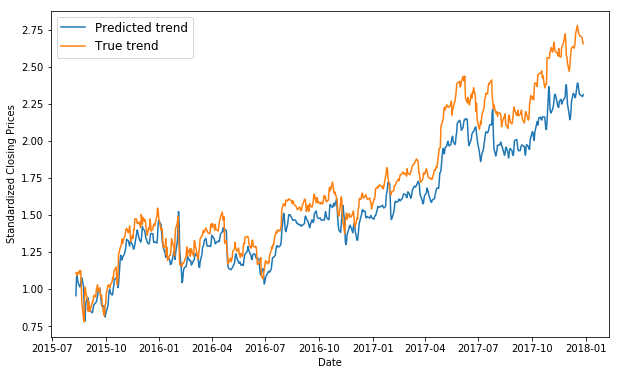

In [87]:
plt.figure(figsize=(10,6))
plt.plot(time_scale_lstm,model_lstm.predict(X_test_lstm),label='Predicted trend')
plt.plot(time_scale_lstm,y_test_lstm,label="True trend")
plt.xlabel("Date")
plt.ylabel("Standardized Closing Prices")
plt.legend(fontsize='large')

# Feed Forward Neural Network Model

In [88]:
start=time.time()
model_dense = create_model_dense()
model_dense.fit(X_train_dense,y_train_dense,epochs=30,batch_size=64)
print("Running Time: "+str(time.time()-start))

Epoch 1/30
2406/2406 [==============================] - 1s 622us/step - loss: 0.0355 - mean_squared_error: 0.0355
Epoch 2/30
2406/2406 [==============================] - 0s 60us/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 3/30
2406/2406 [==============================] - 0s 57us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 4/30
2406/2406 [==============================] - 0s 56us/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 5/30
2406/2406 [==============================] - 0s 58us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 6/30
2406/2406 [==============================] - 0s 59us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 7/30
2406/2406 [==============================] - 0s 57us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 8/30
2406/2406 [==============================] - 0s 57us/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 9/30
2406/2406 [==============================] - 0s 60us/step - loss: 0.0012 - mean_squa

In [0]:
time_scale_dense=(stock_data.iloc[-603:-1,3:4].index)

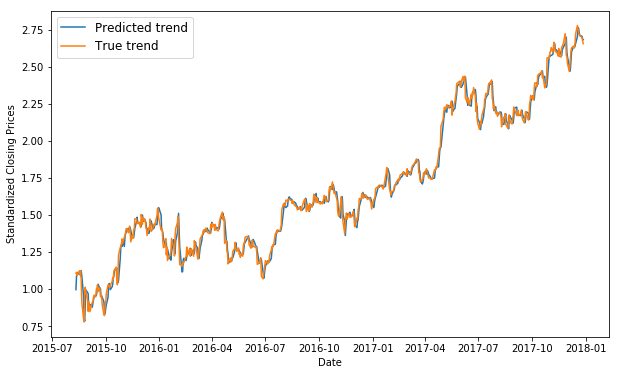

In [90]:
plt.figure(figsize=(10,6))
plt.plot(time_scale_dense,model_dense.predict(X_test_dense),label='Predicted trend')
plt.plot(time_scale_dense,y_test_dense,label="True trend")
plt.xlabel("Date")
plt.ylabel("Standardized Closing Prices")
plt.legend(fontsize='large')

### Code for GridSearchCV experiment(don't need to run)

In [0]:
# # # create model
# model = KerasRegressor(build_fn=create_model,verbose=0)
# # # define the grid search parameters
# neurons_lstm1 = np.arange(10,110,10)
# neurons_lstm2 = np.arange(10,110,10)
# # neurons_dense1 = np.arange(10,110,10)
# epochs=np.arange(5,31,5)
# batch_size=[32,64,128,256,512]
# param_grid = dict(epochs=epochs,batch_size=batch_size)
# grid = GridSearchCV(estimator=model,scoring='neg_mean_squared_error',param_grid=param_grid, n_jobs=-1)
# grid_result = grid.fit(X_train, y_train)
# grid_result.best_params_

# Generalized Linear Regression

In [0]:
poly = PolynomialFeatures(degree=1)#Mapping to Higher Dimension
mapped_data = poly.fit_transform(std_stockdata[:,0:4])
X_train_l,X_test_l,y_train_l,y_test_l=train_test_split(mapped_data,std_stockdata[:,4],test_size=0.2, shuffle=False)

In [0]:
time_scale_l=(stock_data.iloc[-605:-1,3:4].index)

Running TIme: 0.00289154052734375


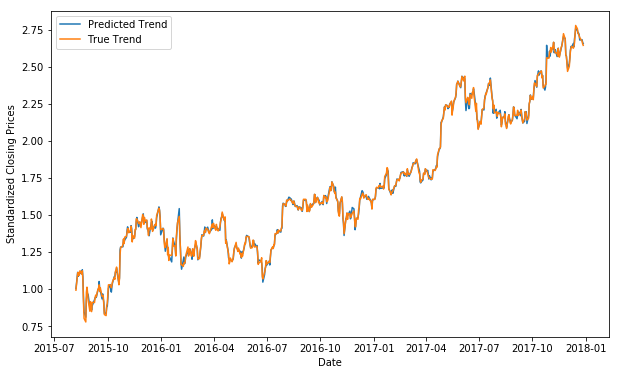

In [94]:
start=time.time()
linreg_model=LinearRegression(fit_intercept=False)
linreg_model.fit(X_train_l,y_train_l)
print("Running TIme: "+str(time.time()-start))
plt.figure(figsize=(10,6))
plt.plot(time_scale_l,linreg_model.predict(X_test_l),label='Predicted Trend')
plt.plot(time_scale_l,y_test_l,label='True Trend')
plt.xlabel("Date")
plt.ylabel("Standardized Closing Prices")
plt.legend()

# SVM

In [0]:
X_train_svm, X_test_svm, y_train_svm,y_test_svm = train_test_split(std_stockdata[:,0:4],std_stockdata[:,4],test_size=0.2, shuffle=False)

### Code for GridSearchCV experiment(don't need to run)

In [0]:
# parameters = [{'kernel': ['linear'], 'gamma': np.arange(0,4.1,0.1),
#                      'C': [1,10,100]}]
# #                     {'kernel': ['linear'], 'C': [1,10,50,100]},
# #                    {'kernel': ['poly'], 'gamma': np.arange(0,4.1,0.1),'degree': [1,2,3,4,5],'C': [1,10,50,100]}]
# svr_model = GridSearchCV(SVR(),parameters,scoring = 'neg_mean_squared_error')
# res=svr_model.fit(X_train_svm,y_train_svm)
# res.best_params_

In [97]:
start=time.time()
model_svm = SVR(kernel='poly',degree=1,gamma=3.1,C=1)
model_svm.fit(X_train_svm,y_train_svm)
print("Running Time: "+str(time.time()-start))

Running Time: 0.014677047729492188


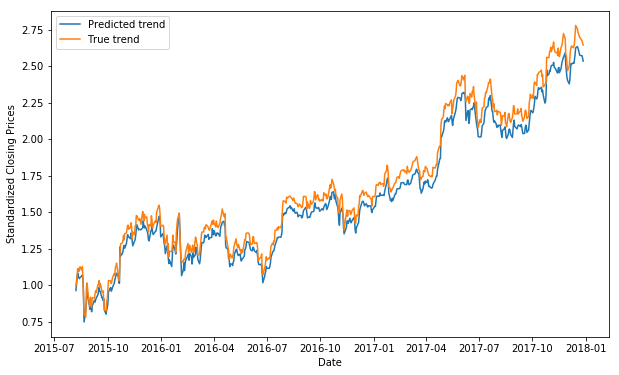

In [98]:
plt.figure(figsize=(10,6))
plt.plot(time_scale_l,model_svm.predict(X_test_svm),label='Predicted trend')
plt.plot(time_scale_l,y_test_svm,label="True trend")
plt.xlabel("Date")
plt.ylabel("Standardized Closing Prices")
plt.legend()